# Make stationary SPG non-stationary

This notebook processes one run of Leroy's stationary SPG.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

from magicc import Magicc
from spg.stationary_converter import StationaryConverter

In [3]:
#pathway = "ssp119"
#pathway = "rcp85"
pathway = "ssp245"
#pathway = "rcp26"

# location = "auckland"
# location = "tauranga"
# location = "christchurch"
location = "dunedin"

spg_run = 1

## Load Weather@Home datasets

In [4]:
t_prime_sh_land = {
    "batch_870_ant": 1.728,
    "batch_871_ant": 2.277,
    "batch_872_ant": 3.384
}

In [5]:
from collections import Counter

def load_weather_at_home(data_path):
    files = sorted(data_path.glob("*.nc"))
    precipitations = []
    incomplete_datasets_count = 0
    for file in files:
        dataset = xr.open_dataset(file)
        if len(dataset['time1']) != 600:
            incomplete_datasets_count += 1
            continue
        dataset = dataset.isel(time1=slice(600-360, 600), z0=0)
        precipitation = dataset["precipitation"].values
        precipitations.append(precipitation)

    precipitations = np.concatenate(precipitations)
    
    # Convert units to mm/day
    precipitations = precipitations * 24*60*60

    processed_count = len(files) - incomplete_datasets_count
    print(f"Processed {processed_count:,} complete files (skipped {incomplete_datasets_count} incomplete datasets).")
    return precipitations

In [6]:
# Load all data
base_data_path = Path(f"/mnt/temp/projects/otago_uni_marsden/data_keep/weather_at_home/{location}/")
weather_at_home = {}
for sim_label in t_prime_sh_land.keys():
    print(f"Loading {sim_label}...")
    data_path = base_data_path / sim_label
    precipitation = load_weather_at_home(data_path)
    weather_at_home[sim_label] = precipitation
print("Finished loading")

Loading batch_870_ant...
Processed 2,543 complete files (skipped 113 incomplete datasets).
Loading batch_871_ant...
Processed 2,496 complete files (skipped 147 incomplete datasets).
Loading batch_872_ant...
Processed 2,549 complete files (skipped 131 incomplete datasets).
Finished loading


## Analyse Weather@Home

In [7]:
def generate_dataframe(quantile):
    sim_labels = weather_at_home.keys()
    temperatures = [t_prime_sh_land[key] for key in sim_labels]
    results_at_quantile = [np.quantile(weather_at_home[key], quantile) for key in sim_labels]

    df = pd.DataFrame({
        "temperature": temperatures,
        "precipitation": results_at_quantile
    })
    df = df.set_index("temperature")
    return df

In [8]:
def analyse_dataframe(df, threshold=0.1):
    if np.any(df["precipitation"] < threshold):
        return None
    
    def func(x, p_zero, rate):
        return p_zero * np.exp(rate*x)

    params, _ = curve_fit(
        func, 
        df.index.to_numpy(), 
        df["precipitation"].to_numpy(),
        p0=[0,0]
    )

    assert params[0] >= 0, "p_zero is negative"

    return {
        "f": func,
        "params": params
    }

In [9]:
def plot_one(df, fit, title):
    if fit is None:
        raise Exception("No fit information")
        
    ax = sns.scatterplot(
        x=df.index,
        y=df["precipitation"],
    )
    xs = np.linspace(
        np.min(df.index),
        np.max(df.index),
        num=1000
    )
    func = fit["f"]
    params = fit["params"]
    ys = func(xs, *params)
    sns.lineplot(
        x=xs,
        y=ys,
        hue=0,
        legend=False,
    )
    ax.set_ylabel("Precipitation (mm/day)")
    ax.set_xlabel("T' SH Land (deg C)")
    ax.set_title(title+f"\np_zero: {params[0]:.2f} mm/day, rate: {params[1]*100:.1f}% per K")
    
    return ax

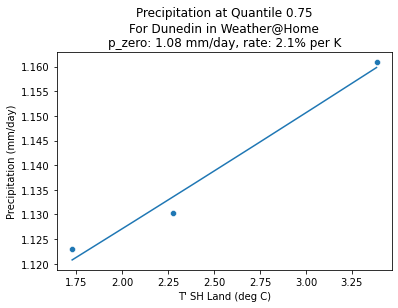

In [10]:
quantile = 0.75
df = generate_dataframe(quantile)
fit = analyse_dataframe(df)
title = f"Precipitation at Quantile {quantile}\nFor {location.title()} in Weather@Home"
ax = plot_one(df, fit, title)
plt.savefig(f"weather-at-home-{location}-75th-percentile.png", bbox_inches="tight", dpi=300)

In [11]:
def save_precipiation_data_as_csv():
    sim_labels = weather_at_home.keys()
    temperatures = [t_prime_sh_land[key] for key in sim_labels]
    qs = np.linspace(0,1, num=1001)
    df = generate_dataframe(qs)
    precips = np.concatenate(df["precipitation"].values).reshape(len(temperatures), (len(qs)))
    ds = xr.Dataset(
        {
            "precipitation": (
                ("temperature","quantile"), 
                precips
            )
        },
        {
            "quantile": qs,
            "temperature": temperatures
        }
    )
    ds.to_dataframe().to_csv(f"weather-at-home-{location}-precipitation-by-tprimeshland-by-quantile.csv")

save_precipiation_data_as_csv()

In [12]:
def analyse_many(quantiles):
    # Loop through quantiles, produce combined dataframe
    p_zeros = []
    rates = []
    qs = []
    for q in quantiles:
        df = generate_dataframe(q)
        try:
            fit = analyse_dataframe(df)
        except:
            print(f"p_zero was negative for quantile {q}")
            continue
        if fit is None:
            continue
        params = fit["params"]
        qs.append(q)
        p_zeros.append(params[0])
        rates.append(params[1])
    result = pd.DataFrame({
        "quantile": qs,
        "p_zero": p_zeros,
        "rate": rates
    })
    return result

In [13]:
quantiles = np.linspace(0,1, num=1001)
df = analyse_many(quantiles)
df.to_csv(f"weather-at-home-{location}-pzero-and-rate-against-quantiles.csv", index=False)
df

,quantile,p_zero,rate
0,0.475,0.104286,-0.009799
1,0.476,0.105366,-0.009403
2,0.477,0.106579,-0.009438
3,0.478,0.107691,-0.009046
4,0.479,0.108873,-0.008794
...,...,...,...
521,0.996,25.159485,0.053023
522,0.997,27.896284,0.054408
523,0.998,31.797635,0.057990
524,0.999,38.730162,0.063067


In [14]:
# Function to interpolate rate given quantile
interpolate_rate = interp1d(
    x=df["quantile"].to_numpy(), 
    y=df["rate"].to_numpy(),
    fill_value="extrapolate"
)

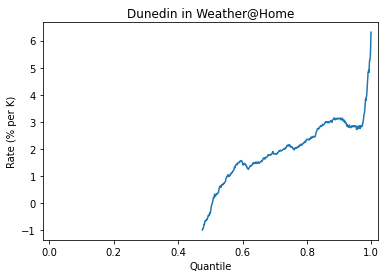

In [15]:
ax = sns.lineplot(
    x=df["quantile"][:-1],
    y=df["rate"][:-1]*100
)
ax.set_title(f"{location.title()} in Weather@Home")
x_margin=0.02
ax.set_xlim(0-x_margin,1+x_margin)
ax.set_ylabel("Rate (% per K)")
ax.set_xlabel("Quantile")

plt.savefig(f"weather-at-home-{location}-rate-against-quantiles.png", bbox_inches="tight", dpi=300)
None # don't return a value

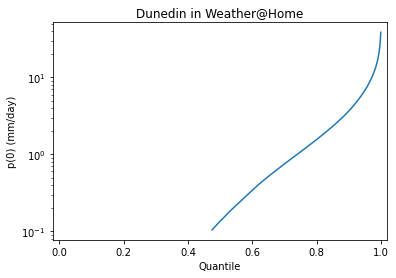

In [16]:
ax = sns.lineplot(
    x=df["quantile"][:-1],
    y=df["p_zero"][:-1]
)
ax.set_title(f"{location.title()} in Weather@Home")
ax.set_yscale("log")
ax.set_xlim(0-x_margin,1+x_margin)
ax.set_ylabel("p(0) (mm/day)")
ax.set_xlabel("Quantile")

plt.savefig(f"weather-at-home-{location}-pzero-against-quantiles.png", bbox_inches="tight", dpi=300)
None # don't return a value

## MAGICC: Date to T'<sub>SH Land</sub>

Leroy created a CSV file with MAGICC data.  We create a function that, given a date, returns the (interpolated) T'<sub>SH Land</sub>.

In [17]:
# Load MAGICC data
magicc = Magicc("../data/magic_tprime_sh_land.csv")
magicc.df.head()

,rcp26,rcp45,rcp60,rcp85,ssp119,ssp126,ssp245,ssp370,ssp434,ssp460,ssp585
date,,,,,,,,,,,
1765-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1766-01-01,0.036236,0.036236,0.036236,0.036236,0.012942,0.012942,0.012942,0.012942,0.012942,0.012942,0.012942
1767-01-01,0.051246,0.051246,0.051246,0.051246,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676,-0.020676
1768-01-01,0.063496,0.063496,0.063496,0.063496,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505,-0.023505
1769-01-01,0.075762,0.075762,0.075762,0.075762,0.013411,0.013411,0.013411,0.013411,0.013411,0.013411,0.013411


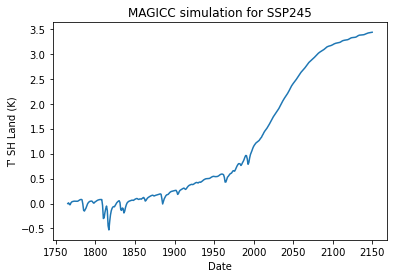

In [18]:
ax = sns.lineplot(x=magicc.df.index, y=magicc.df[pathway])
ax.set_title(f"MAGICC simulation for {pathway.upper()}")
ax.set_ylabel("T' SH Land (K)")
ax.set_xlabel("Date")
None # don't return a value

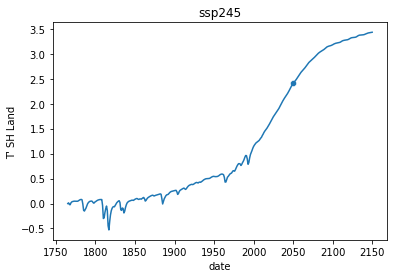

In [19]:
# Demonstrate that the interpolation gives the expected results
ax = sns.lineplot(x=magicc.df.index, y=magicc.df[pathway])

date = np.datetime64("2050-06-01")
convert_date_to_tprime = magicc.create_interpolator(pathway)
sns.scatterplot(x=[date], y=convert_date_to_tprime(date))

ax.set_title(pathway)
ax.set_ylabel("T' SH Land")
None # don't return a value

## Load observed data to obtain "average" t_prime used in training

We consider that the stationary SPG is effectively producing precipitation for the average T'SHLand that it was exposed to during training.

In [20]:
observations_filenames = {
    "auckland": "auckland.nc",
    "tauranga": "tauranga.nc",
    "christchurch": "christchurch.nc",
    "dunedin": "dunedin_combined.nc"
}
observations_filename = observations_filenames[location]

In [21]:
# Load observed dataset
observations_path = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/station_data_hourly") / observations_filename
observation_ds = xr.open_dataset(observations_path)
observation_ds

<xarray.Dataset>
Dimensions:        (time: 440879)
Coordinates:
  * time           (time) datetime64[ns] 1962-11-09T23:00:00 ... 2019-08-01
Data variables:
    precipitation  (time) float64 ...
    tprime         (time) float64 ...
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  /spg/data_processing/find_stations.py
    creation_date:  2022/02/10, 17:09
    git_sha:        21823b83a6055d32217100d6feb56ba1b21b9860
    author:         Leroy
    email:          leroy@bodekerscientific.com

In [22]:
# Training data was everything but the last 10,000 entries (see config/base_hourly.yml)
observation_ds = observation_ds.sel(time=observation_ds["time"][:-10000])
observation_ds

<xarray.Dataset>
Dimensions:        (time: 430879)
Coordinates:
  * time           (time) datetime64[ns] 1962-11-09T23:00:00 ... 2018-06-05T2...
Data variables:
    precipitation  (time) float64 ...
    tprime         (time) float64 ...
Attributes:
    git_remote:     https://github.com/bodekerscientific/SPG
    relative_path:  /spg/data_processing/find_stations.py
    creation_date:  2022/02/10, 17:09
    git_sha:        21823b83a6055d32217100d6feb56ba1b21b9860
    author:         Leroy
    email:          leroy@bodekerscientific.com

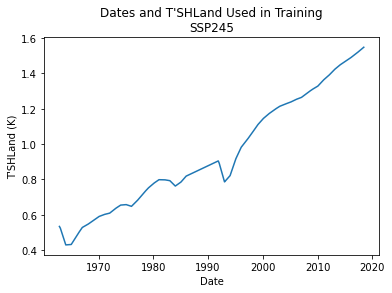

In [23]:
# Get t_prime values for all training dates
t_primes = convert_date_to_tprime(observation_ds["time"])
ax = sns.lineplot(
    x=observation_ds["time"],
    y=t_primes
)
ax.set_ylabel("T'SHLand (K)")
ax.set_xlabel("Date")
ax.set_title(f"Dates and T'SHLand Used in Training\n{pathway.upper()}")
None # don't return anything

In [24]:
# "Average" t_prime for the training data
t_prime_training = np.mean(t_primes)
print(f"Average t_prime used in training: {t_prime_training:.2f}K")

Average t_prime used in training: 0.95K


## Load output of stationary SPG

In [25]:
stationary_converter = StationaryConverter()

In [26]:
# Load stationary output
location_to_folder = {
    "auckland": "auckland_epoch_010",
    "tauranga": "tauranga_epoch_003",
    "christchurch": "christchurch_epoch_008",
    "dunedin": "dunedin_epoch_009"
}

# Note that the pathway and dates are not important information
base_path = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/ensemble_hourly_paper/v10")
file_path = base_path / location_to_folder[location] / f"{location}_{pathway}_{spg_run:03d}.nc"
stationary_converter.load_stationary_spg_output(file_path)

Loading hourly stationary-SPG output from /mnt/temp/projects/otago_uni_marsden/data_keep/spg/ensemble_hourly_paper/v10/dunedin_epoch_009/dunedin_ssp245_001.nc


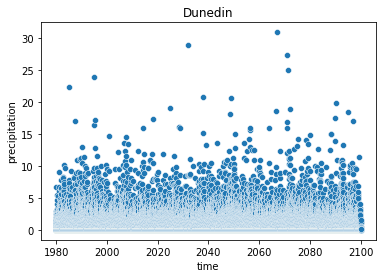

In [27]:
ax = sns.scatterplot(
    x=stationary_converter.hourly_ds["time"],
    y=stationary_converter.hourly_ds["precipitation"]
)
ax.set_title(location.title())
None # don't return a value

## Resample hourly data to daily

Weather@Home is on a daily basis.  Resampling to a daily frequency allows comparison to Weather@Home.

In [28]:
stationary_converter.resample_to_daily()

Resampling hourly data to daily


## Generate delta t_prime compared to training

In [29]:
stationary_converter.calc_delta_t_prime(
    convert_date_to_tprime,
    t_prime_training
)

Calculating delta t_prime


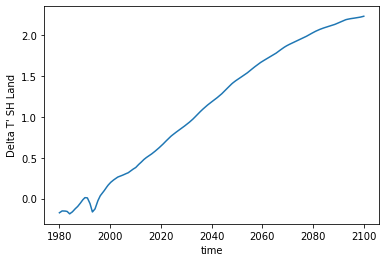

In [30]:
ax = sns.lineplot(
    x=stationary_converter.daily_ds["time"],
    y=stationary_converter.daily_ds["delta_t_prime"]
)
ax.set_ylabel("Delta T' SH Land")
None # don't return anything

## Convert the precipitation to its quantile

In [31]:
stationary_converter.convert_precipitation_to_quantile()

Converting precipitation to quantile


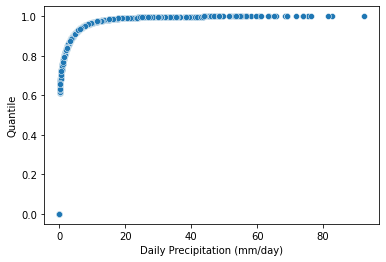

In [32]:
# Obtain the mapping from value to quantile
precipitations = stationary_converter.daily_ds["precipitation"].to_numpy()
quantiles = stationary_converter.daily_ds["quantile"].to_numpy()
ax = sns.scatterplot(
    x=precipitations,
    y=quantiles
)
ax.set_xlabel("Daily Precipitation (mm/day)")
ax.set_ylabel("Quantile")
None # don't return a value

<AxesSubplot:ylabel='Count'>

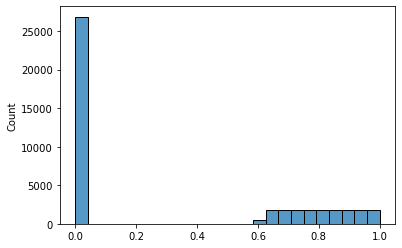

In [33]:
sns.histplot(stationary_converter.daily_ds["quantile"])

## Find rate, given quantile

In [34]:
stationary_converter.calc_rate(interpolate_rate)

Calculating rates


<AxesSubplot:xlabel='quantile', ylabel='rate'>

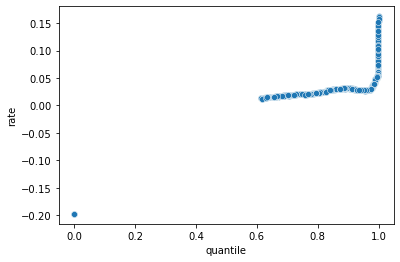

In [35]:
sns.scatterplot(
    x=stationary_converter.daily_ds["quantile"],
    y=stationary_converter.daily_ds["rate"]
)

## Calculate multiplier, given rate and delta T'

In [36]:
stationary_converter.calc_multiplier()

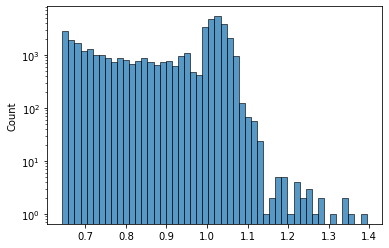

In [37]:
ax = sns.histplot(
    stationary_converter.daily_ds["multiplier"],
    bins=50
)
ax.set_yscale("log")

## Calculate non-stationary precipitation

In [38]:
stationary_converter.calc_daily_non_stationary_precipitation()

In [39]:
x=sorted(stationary_converter.daily_ds["precipitation"].to_numpy())
y=sorted(stationary_converter.daily_ds["non_stationary_precipitation"].to_numpy())

Text(0, 0.5, 'Non-Stationary')

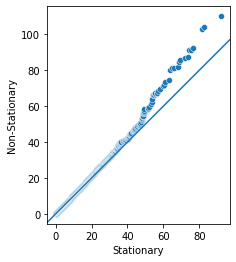

In [40]:
ax = sns.scatterplot(x=x,y=y)
ax.axline((0,0), slope=1)
ax.set_aspect("equal")
ax.set_xlabel("Stationary")
ax.set_ylabel("Non-Stationary")

In [41]:
filepath = f"non_stationary_daily_{location}_{pathway}_{spg_run:03d}.nc"
stationary_converter.save_daily(filepath)

Saving non_stationary_daily_dunedin_ssp245_001.nc


## Convert hourly data using daily multipliers

In [42]:
stationary_converter.calc_hourly_non_stationary_precipitation(
    convert_date_to_tprime
)

Calculating hourly non-stationary precipitation from daily


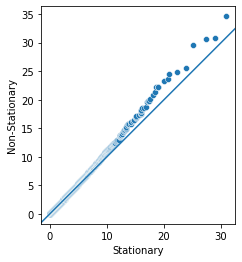

In [43]:
x=sorted(stationary_converter.hourly_ds["precipitation"].to_numpy())
y=sorted(stationary_converter.hourly_ds["non_stationary_precipitation"].to_numpy())

ax = sns.scatterplot(x=x,y=y)
ax.axline((0,0), slope=1)
ax.set_aspect("equal")
ax.set_xlabel("Stationary")
ax.set_ylabel("Non-Stationary")
None # don't return a value

In [44]:
filepath = f"non_stationary_hourly_{location}_{pathway}_{spg_run:03d}.nc"
stationary_converter.save_hourly(filepath)

Saving non_stationary_hourly_dunedin_ssp245_001.nc
